# Examen TNS 2021-2022

## Evaluation
Vous serez évalué par groupe de 3 (à l'exception d'un groupe 4) lors d'une soutenance orale de 10 min lors de laquelle vous présenterez vos travaux. La présentation se fera en détaillant le notebook. La note sera principalement basée sur votre capacité à restituer de façon claire les notions de cours. Il est donc essentiel d'introduire dans le notebook la logique de votre travail.
La présentation se fait à trois voix et sera suivi d'une séance de questions.

Les notebooks devront être transmis par e-mail 2 jours avant la restitution orale

Les données devront mettre en oeuvre des traitements relatifs au cours TNS (donc essentiellement sur des signaux et non des méthodes de traitement d'image)

## Description de l'examen
L'examen a pour but de traiter un radargramme c'est-à-dire les données acquises par un géoradar.

Le géoradar est composé d’un châssis équipé de deux ou quatre roues sur lequel est posé en son centre l’antenne émettrice ('E') et l’antenne réceptrice ('R') très proches du sol. Il dispose également d’un odomètre qui positionne spatialement les réflexions enregistrées sous forme de signal 1D.

<img src="img/Georadar.PNG" style="height:200px">

Le géoradar émet une onde électromagnétique dans le sol sous forme de brèves impulsions à intervalle
régulier. La forme de l’impulsion émise ressemble à une ondelette de Ricker. Lorsque l’onde rencontre une discontinuité, qui se traduit par une différence de permittivité diélectrique entre deux milieux, une partie de l’énergie est réfléchie et une autre transmise. L’ensemble des ondes réfléchies parvenant jusqu’à l’antenne réceptrice est enregistré en fonction du temps.
À chaque impulsion émise, une réponse que l’on appelle trace (ou A-Scan), est stockée sous forme de signal monodimensionnel. L’opérateur, en déplaçant le géoradar va collecter un ensemble de traces qui formeront un radargramme (ou B-Scan)

<img src="img/fonctionnement_georadar2.PNG" style="height:350px">

## Les données
Pour le radargramme traité, les signaux sont enregistrés pendant 62 ns et la longueur de déplacement est de 13 m.

 ### Clutter
La configuration d’antenne avec l’émetteur et le récepteur à la fois très proche l’un de l’autre et très proche du sol implique qu’un premier enregistrement survient très rapidement, appelé onde directe. L’onde directe est très peu atténuée et par conséquent le signal enregistré a une très forte amplitude. De plus, la multiple-réverbération de l’onde avec la surface fait apparaître des formes très horizontales en arrière-plan qui se répètent verticalement sur le radargramme, appelé ringing en anglais.

### Bruit
Le bruit provient de perturbations aléatoires issues des appareils de mesures. Du fait de la très large bande passante de l’antenne, le bruit peut également apparaitre à la suite de l’enregistrement des signaux provenant des ondes électromagnétiques
dans l’air issues des antennes de radio-transmission et des appareils téléphoniques. Dans ce dernier cas des artefacts en forme de colonne apparaissent sur les données. Le bruit apparait essentiellement en fin d’enregistrement d’une trace en l’absence d’information et rehaussé par le gain appliqué en profondeur.

<img src="img/artefacts.PNG" style="height:200px">

In [1]:
import scipy.io

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import signal

In [2]:
gprdata = scipy.io.loadmat('DZT_GDF001.mat')

bs = gprdata['radarDZT']
bs = bs.astype(np.int32)

In [3]:
def plot_radargram(bs, name):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.imshow(bs, cmap="gray")
    
    nb_x_ticks = 14
    x = np.linspace(0,13,nb_x_ticks)
    x = x.astype(np.uint32)
    ax.set_xticks(np.linspace(0,bs.shape[1],nb_x_ticks))
    ax.set_xticklabels(x)
    plt.xlabel("GPR displacement in meters")
        
    nb_y_ticks = 8
    y = np.linspace(0,62,nb_y_ticks)
    y = y.astype(np.uint32)
    ax.set_yticks(np.linspace(0,bs.shape[0],nb_y_ticks))
    ax.set_yticklabels(y)
    plt.ylabel("Time in nanoseconds before reception")
    
    plt.title(name)
    plt.show()

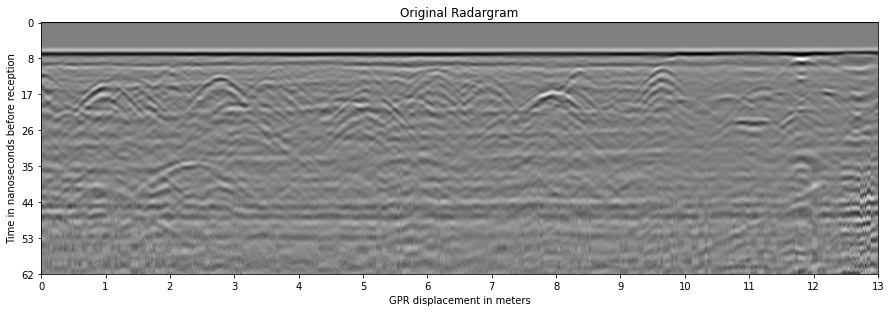

In [8]:
plot_radargram(bs, "Original Radargram")

# Analyse spectrale
A faire selon l'axe temporel et l'axe spatial en 1D

## Analyse spectrale horizontale

In [9]:
def horizontal_spectrum(signal, sample_rate, index_sample):
    spatial_samples = signal
    x = np.linspace(0,13,bs.shape[1])
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("The " + str(index_sample) + "th horizontal sample temporal signal")
    plt.xlabel("GPR displacement in meter")
    plt.plot(x, spatial_samples)

    plt.subplot(1,2,2)
    fourier_spatial = np.fft.rfft(spatial_samples)
    freq = np.fft.rfftfreq(signal.size, d=1./sample_rate)
    plt.title("The horizontal spectrum at the " + str(index_sample) + "th sample")
    plt.plot(freq[1:], np.abs(fourier_spatial[1:]))
    plt.xlabel("Horizontal frequency in m^-1")
    plt.show()

In [10]:
horizontal_sample_rate = bs.shape[1]/13 # The gpr moves 13 meters in total with 1705 samples
print("The horizontal sample rate is " + str(horizontal_sample_rate) + " m^-1")

The horizontal sample rate is 131.15384615384616 m^-1


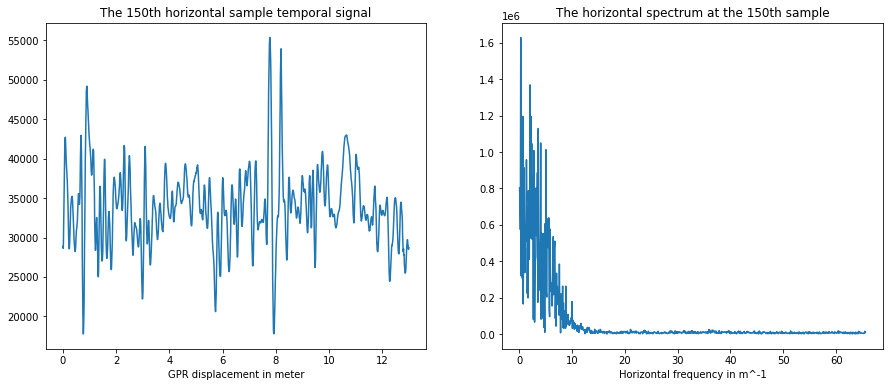

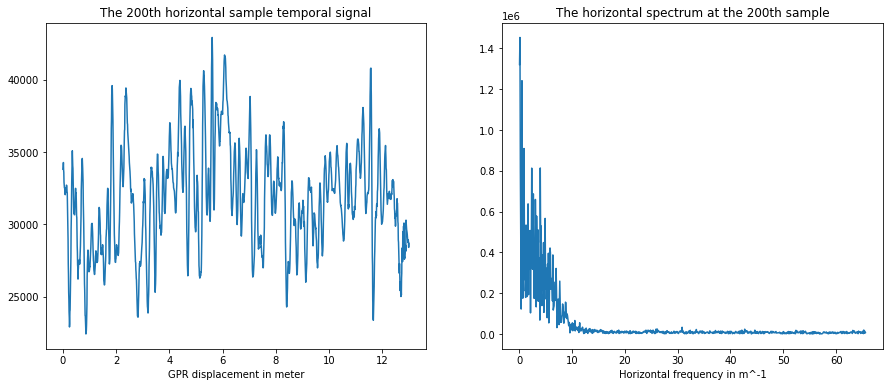

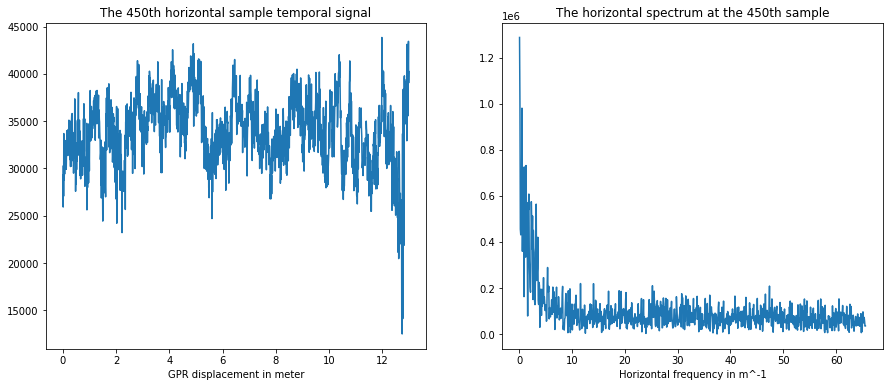

In [11]:
horizontal_spectrum(bs[150], horizontal_sample_rate, 150)
horizontal_spectrum(bs[200], horizontal_sample_rate, 200)
horizontal_spectrum(bs[450], horizontal_sample_rate, 450)

On peut voir que dans les zones où il y a une majorité d'information que l'on veut conserver, les fréquences en m^-1 convergent vers 0 aux alentours de 10-20 m^-1.

Au contraire, dans les zones où il y a du clutter avec des traits horizontaux, l'analyse spectrale révèle que le spectre ne converge pas vers 0 comme dans les spectres précédents. On peut faire la supposition que ces hautes fréquences correspondent au phénomène de clutter et que nous pouvons les retirer grâce à un filtre passe-bas.

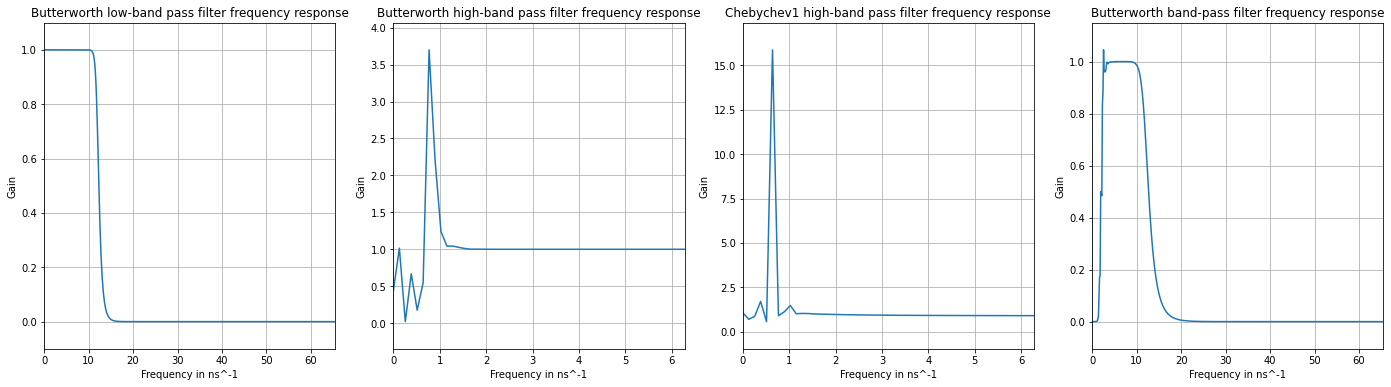

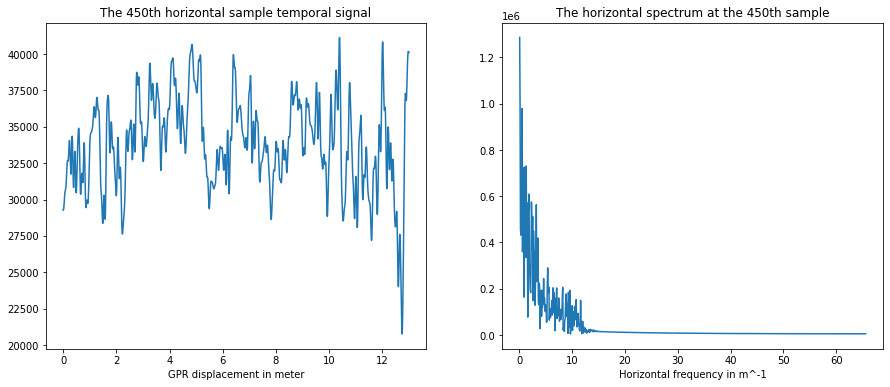

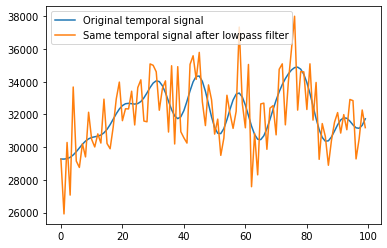

In [72]:
horizontal_low = 0.2
horizontal_high = 12
plt.figure(figsize=(24,6))
plt.subplot(1,4,1)
b, a = signal.butter(20, horizontal_high, 'lp', analog=False, fs=horizontal_sample_rate)
w, h = signal.freqz(b, a)
plt.plot((horizontal_sample_rate * 0.5 / np.pi) * w, abs(h))
plt.title('Butterworth low-band pass filter frequency response')
plt.xlabel('Frequency in ns^-1')
plt.ylabel('Gain')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')

plt.subplot(1,4,2)
b, a = signal.butter(10, horizontal_low, 'hp', analog=False, fs=horizontal_sample_rate)
w, h = signal.freqz(b, a)
plt.plot((horizontal_sample_rate * 0.5 / np.pi) * w[:50], abs(h[:50]))
plt.title('Butterworth high-band pass filter frequency response')
plt.xlabel('Frequency in ns^-1')
plt.ylabel('Gain')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')

plt.subplot(1,4,3)
b, a = signal.cheby1(10, 1, horizontal_low, 'hp', analog=False, fs=horizontal_sample_rate)
w, h = signal.freqz(b, a)
plt.plot((horizontal_sample_rate * 0.5 / np.pi) * w[:50], abs(h[:50]))
plt.title('Chebychev1 high-band pass filter frequency response')
plt.xlabel('Frequency in ns^-1')
plt.ylabel('Gain')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')

plt.subplot(1,4,4)
b, a = signal.butter(9, [horizontal_low, horizontal_high], 'band', analog=False, fs=horizontal_sample_rate)
w, h = signal.freqz(b, a)
plt.plot((horizontal_sample_rate * 0.5 / np.pi) * w, abs(h))
plt.title('Butterworth band-pass filter frequency response')
plt.xlabel('Frequency in ns^-1')
plt.ylabel('Gain')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()


sos = signal.butter(10, horizontal_high, 'lp', fs=horizontal_sample_rate, output='sos')
filtered = signal.sosfiltfilt(sos, bs[450])
horizontal_spectrum(filtered, horizontal_sample_rate, 450)

fig, ax = plt.subplots()
last_value = 100
ax.plot(filtered[:last_value], label="Original temporal signal")
ax.plot(bs[450][:last_value], label="Same temporal signal after lowpass filter")
ax.legend()
plt.show()

In [73]:
def filter_by_butterworth(radargram, cutoff_freq, sample_rate, filter_type, vertical, order=10):
    if (vertical):
        axis=0
    else:
        axis=-1
    sos = signal.butter(order, cutoff_freq, filter_type, fs=sample_rate, output='sos')
    return signal.sosfiltfilt(sos, radargram, axis=axis)

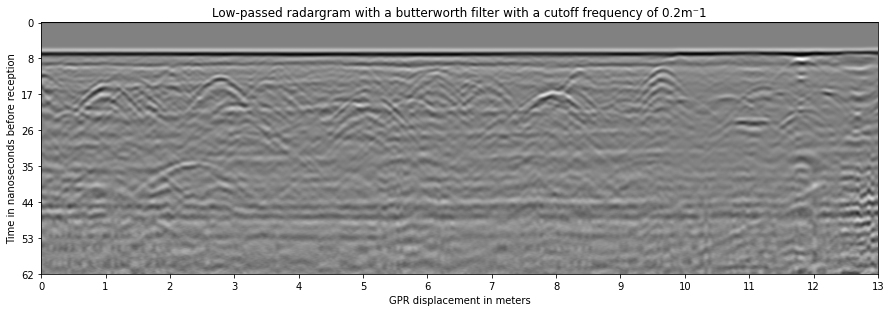

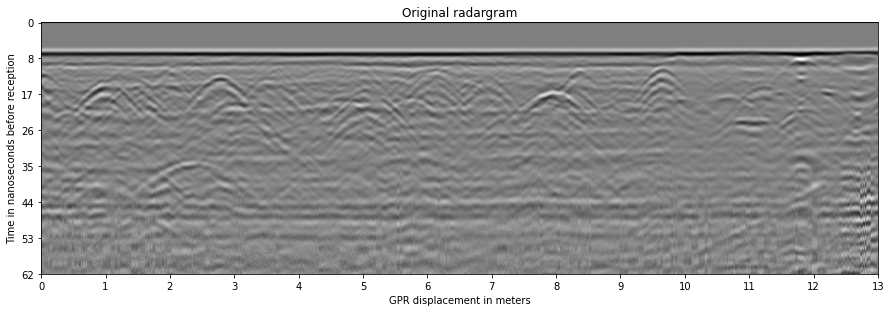

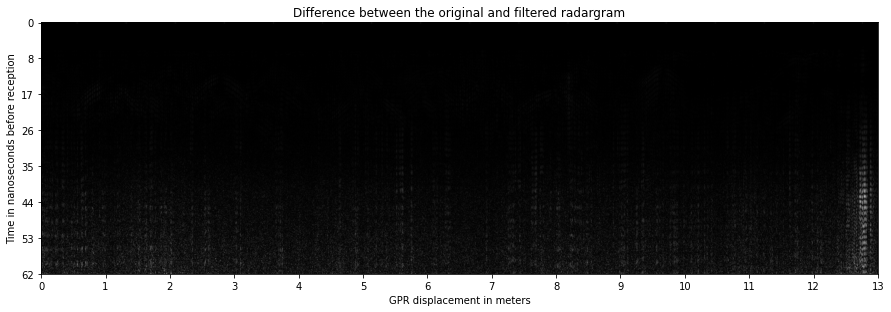

In [74]:
bs_butterworthed = filter_by_butterworth(bs, horizontal_high, horizontal_sample_rate, 'lp', False)
plot_radargram(bs_butterworthed, "Low-passed radargram with a butterworth filter with a cutoff frequency of " + str(horizontal_low) + "m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_butterworthed), "Difference between the original and filtered radargram")

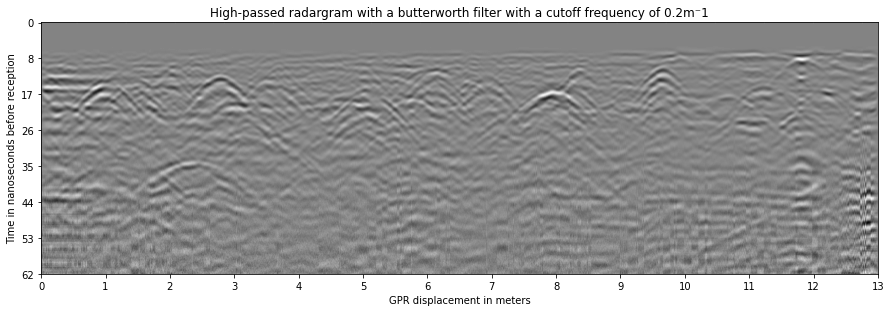

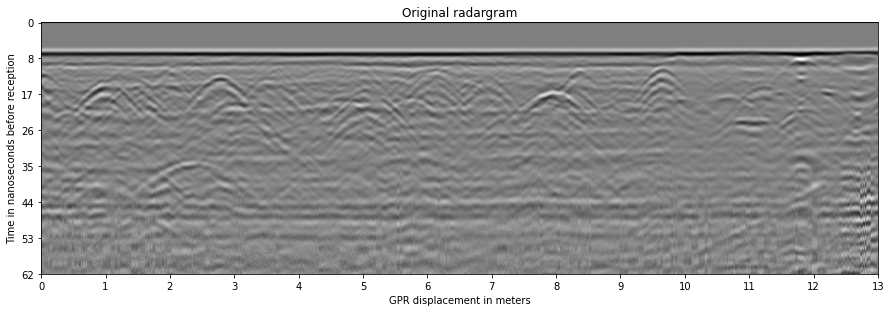

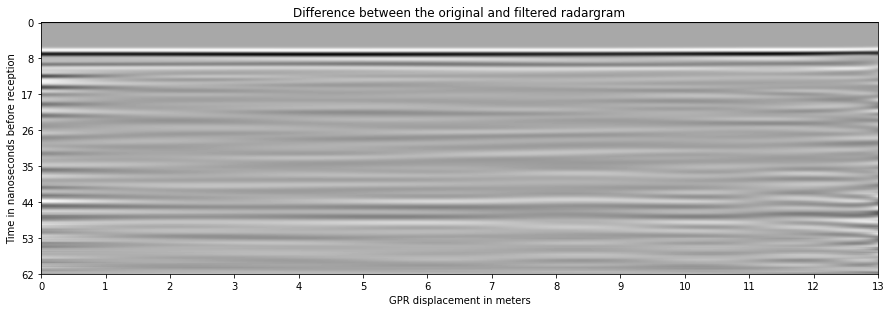

In [75]:
bs_butterworthed = filter_by_butterworth(bs, horizontal_low, horizontal_sample_rate, 'hp', False)
plot_radargram(bs_butterworthed, "High-passed radargram with a butterworth filter with a cutoff frequency of " + str(horizontal_low) + "m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_butterworthed), "Difference between the original and filtered radargram")

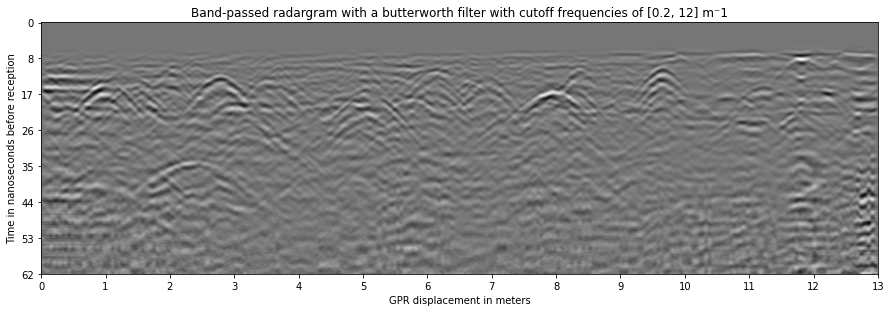

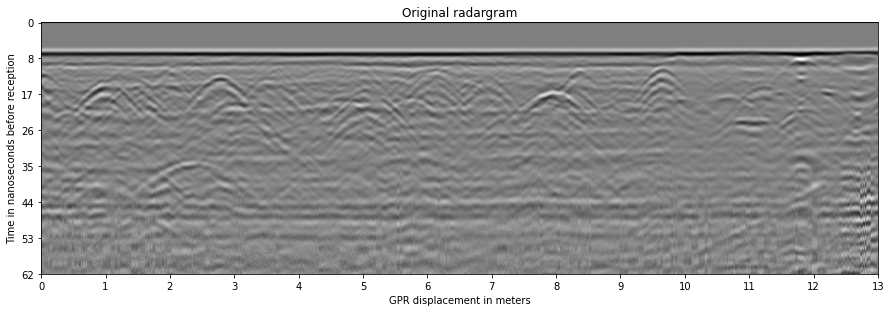

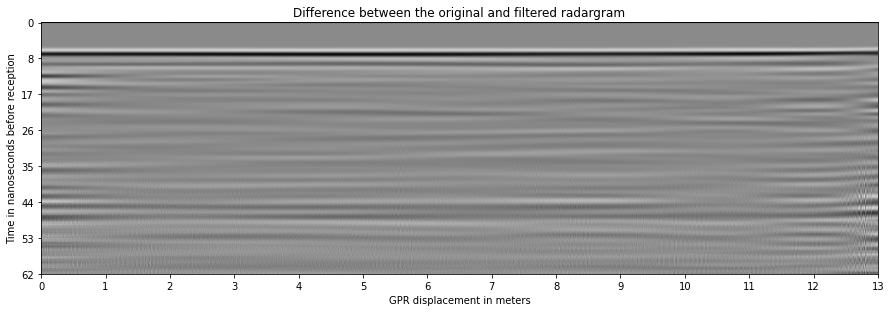

In [76]:
bs_horizontal_filtered = filter_by_butterworth(bs, [horizontal_low, horizontal_high], horizontal_sample_rate, 'band', False)
plot_radargram(bs_horizontal_filtered, "Band-passed radargram with a butterworth filter with cutoff frequencies of [" + str(horizontal_low) + ", " + str(horizontal_high) + "] m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_horizontal_filtered), "Difference between the original and filtered radargram")

## Analyse spectrale vertical

In [77]:
def vertical_spectrum(signal, sample_rate, index_sample, index_begin=0, index_end=512):
    nb_samples = index_end - index_begin
    spatial_samples = signal[index_begin:index_end]
    x = np.linspace((index_begin/512)*62, (index_end/512)*62, nb_samples)
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("The " + str(index_sample) + "th vertical sample temporal signal")
    plt.xlabel("Time in nanoseconds before reception")
    plt.plot(x, spatial_samples)

    plt.subplot(1,2,2)
    fourier_spatial = np.fft.rfft(spatial_samples)
    freq = np.fft.rfftfreq(spatial_samples.size, d=1./sample_rate)
    plt.title("The vertical spectrum at the " + str(index_sample) + "th sample")
    plt.plot(freq[1:], np.abs(fourier_spatial[1:]))
    plt.xlabel("Vertical frequency in ns^-1")
    plt.show()

In [78]:
vertical_sample_rate = 512/62 # On a 512 samples pour 62 nanosecondes de temps de réception
print("The vertical sample rate is " + str(vertical_sample_rate) + " ns^-1")

The vertical sample rate is 8.258064516129032 ns^-1


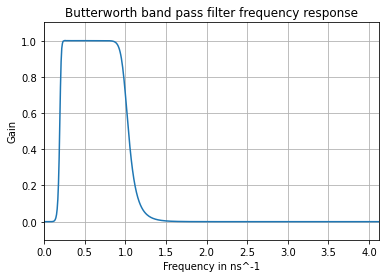

In [82]:
vertical_low = 0.2
vertical_high = 1.0
b, a = signal.butter(9, [vertical_low, vertical_high], 'band', analog=False, fs=vertical_sample_rate)
w, h = signal.freqz(b, a)
plt.plot((vertical_sample_rate * 0.5 / np.pi) * w, abs(h))
plt.title('Butterworth band pass filter frequency response')
plt.xlabel('Frequency in ns^-1')
plt.ylabel('Gain')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

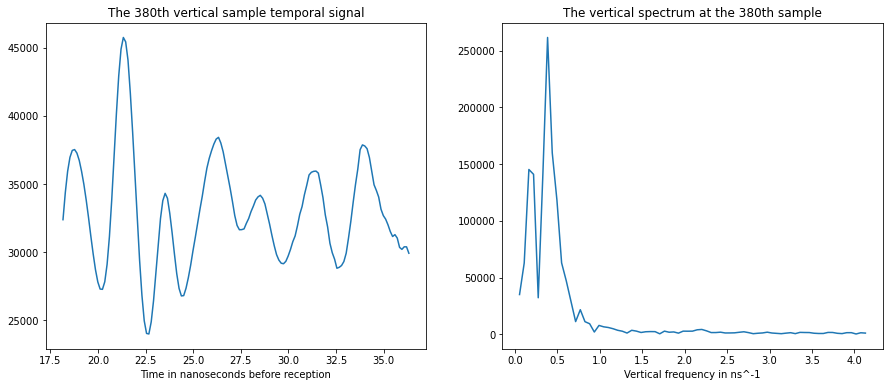

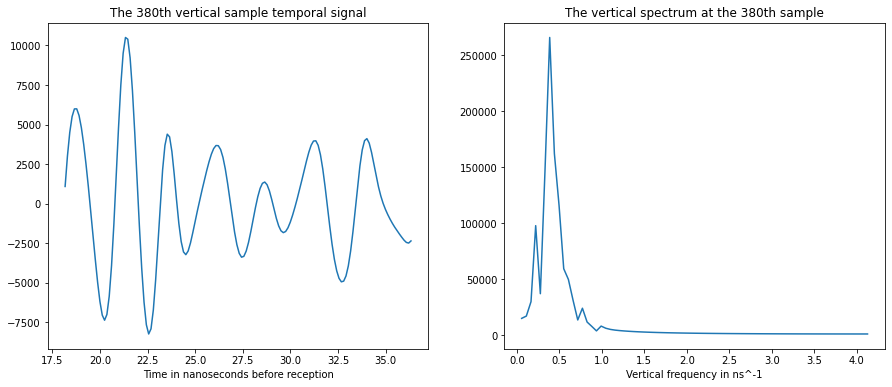

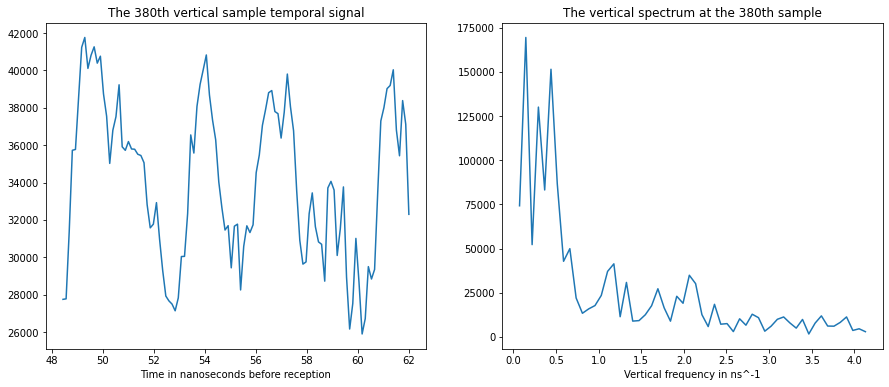

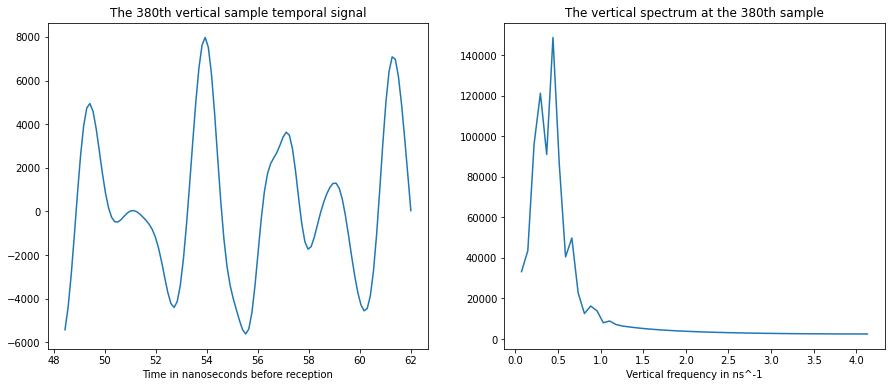

In [85]:
sos = signal.butter(9, [vertical_low, vertical_high], 'bp', fs=vertical_sample_rate, output='sos')
bs_trace_lowpass = signal.sosfiltfilt(sos, bs[:,380])

vertical_spectrum(bs[:,380], vertical_sample_rate, 380, 150, 300)
vertical_spectrum(bs_trace_lowpass, vertical_sample_rate, 380, 150, 300)

vertical_spectrum(bs[:,380], vertical_sample_rate, 380, 400, 512)
vertical_spectrum(bs_trace_lowpass, vertical_sample_rate, 380, 400, 512)

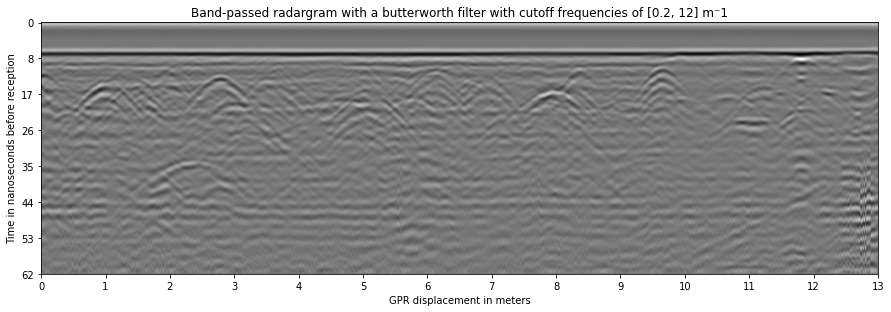

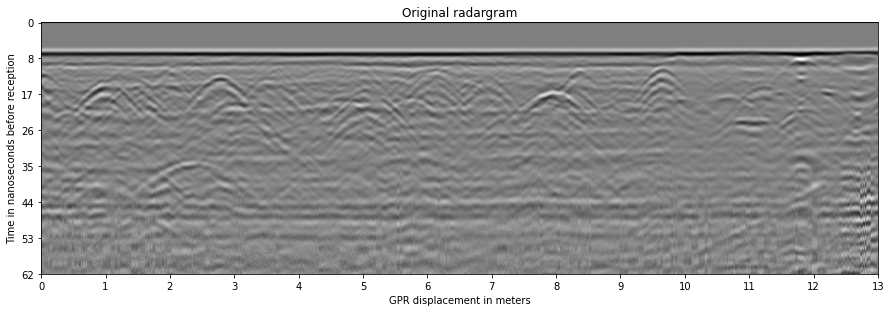

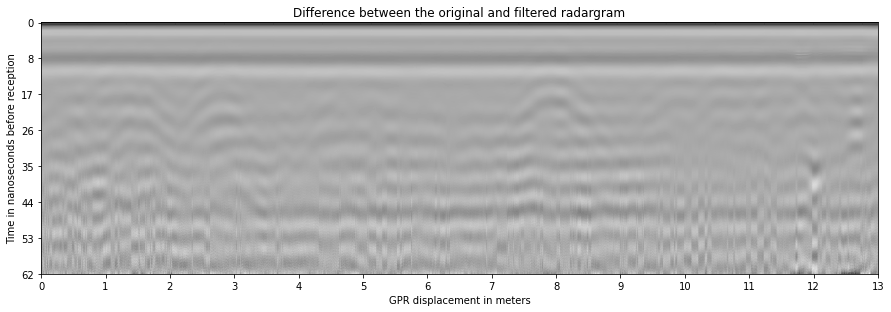

In [87]:
bs_vertical_filtered = filter_by_butterworth(bs, [vertical_low, vertical_high], vertical_sample_rate, 'band', vertical=True, order=9)
plot_radargram(bs_vertical_filtered, "Band-passed radargram with a butterworth filter with cutoff frequencies of [" + str(horizontal_low) + ", " + str(horizontal_high) + "] m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_vertical_filtered), "Difference between the original and filtered radargram")

## Traitement des données

### Archive : Filtrage de l'onde directe et du ringing: Suppression de l'arrière plan

Application d'un mean filter pour enlever l'arrière plan

In [94]:
def apply_mean(radargram):
    mean = np.mean(bs, axis=1)
    return radargram - np.repeat(np.expand_dims(mean, axis=-1), bs.shape[1], axis=1)

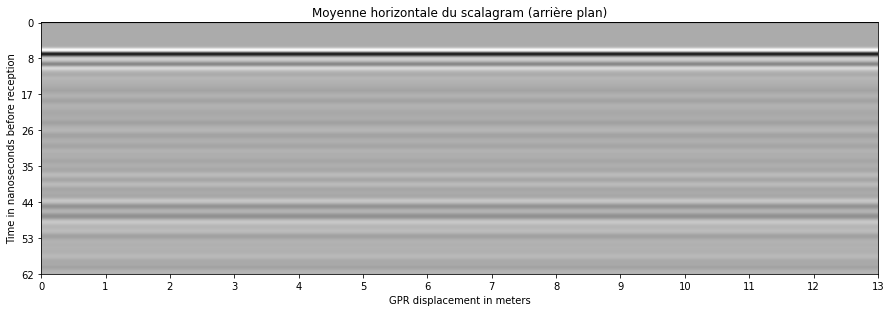

In [95]:
bs_mean = np.repeat(np.expand_dims(np.mean(bs, axis=1), axis=-1), bs.shape[1], axis=1)

plot_radargram(bs_mean, "Moyenne horizontale du scalagram (arrière plan)")

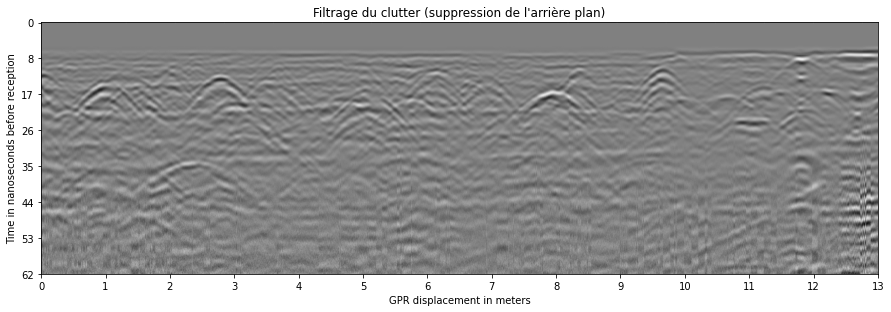

In [96]:
bs_without_mean = apply_mean(bs)
plot_radargram(bs_without_mean, "Filtrage du clutter (suppression de l'arrière plan)")

## Application de toutes les solutions

### Ancienne solution
On appliquait deux filtres passe-bas verticalement et horizontalement et on enlevait la moyenne ensuite.

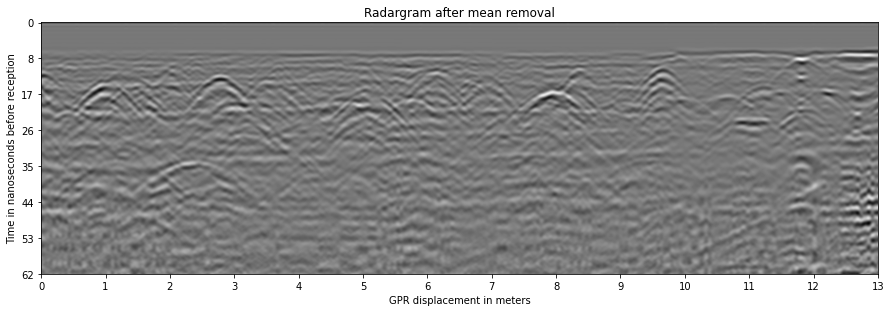

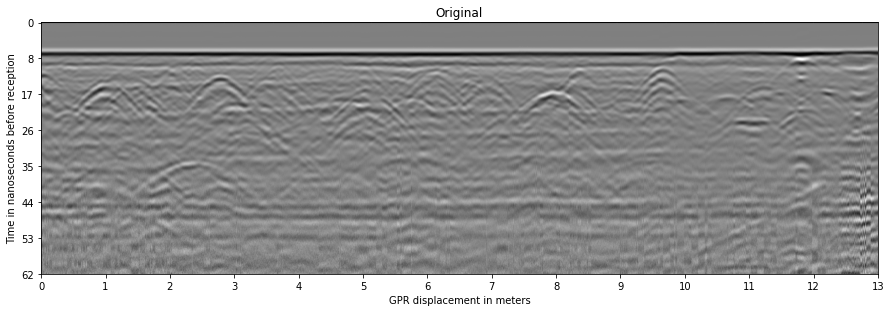

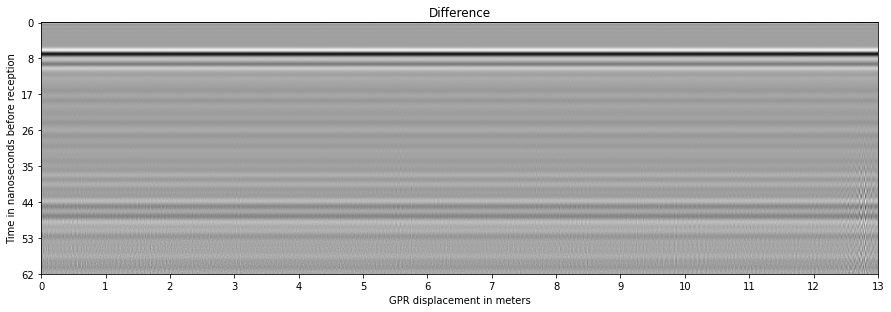

In [99]:
bs_vertical_filtered = filter_by_butterworth(bs, vertical_high , vertical_sample_rate, 'lp', vertical=True, order=9)
bs_horizontal_filtered = filter_by_butterworth(bs_vertical_filtered, horizontal_high, horizontal_sample_rate, 'lp', vertical=False)
bs_filtered_old = apply_mean(bs_horizontal_filtered)
plot_radargram(bs_filtered_old, "Radargram after mean removal")
plot_radargram(bs, "Original")
plot_radargram(np.abs(bs - bs_filtered_old), "Difference")

### Solution finale

On applique deux filtres passe-bandes verticalement et horizontalement

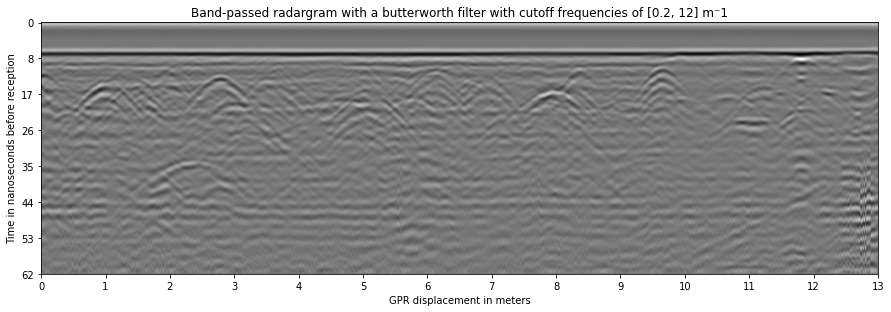

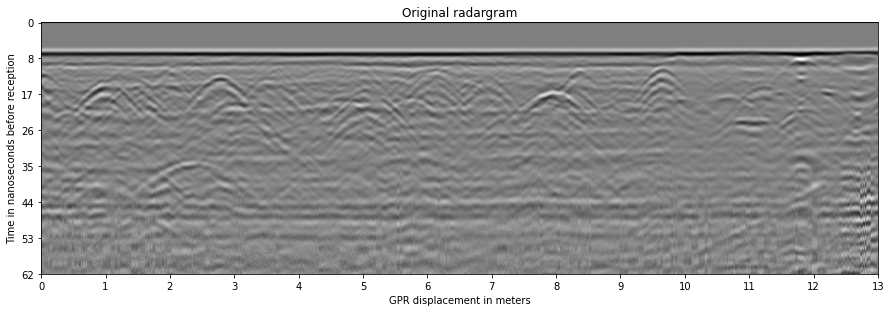

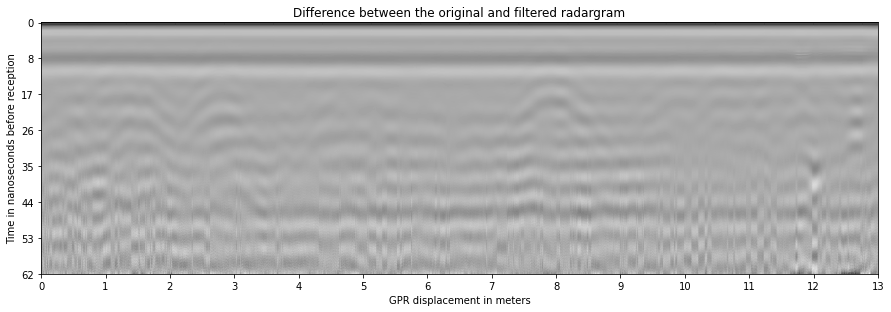

In [102]:
# Application filtre verticale
bs_vertical_filtered = filter_by_butterworth(bs, [vertical_low, vertical_high] , vertical_sample_rate, 'band', vertical=True, order=9)
plot_radargram(bs_vertical_filtered, "Band-passed radargram with a butterworth filter with cutoff frequencies of [" + str(horizontal_low) + ", " + str(horizontal_high) + "] m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_vertical_filtered), "Difference between the original and filtered radargram")

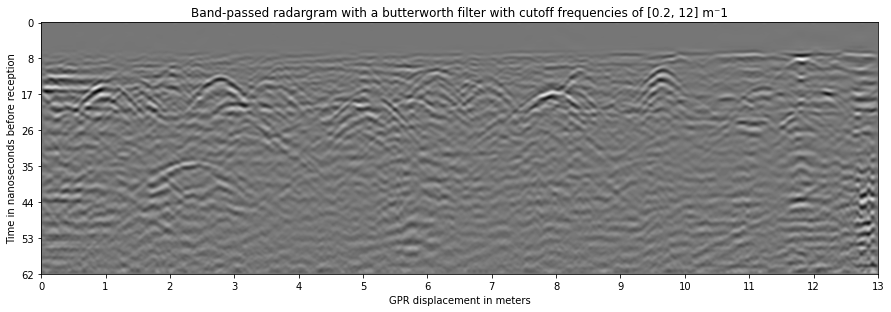

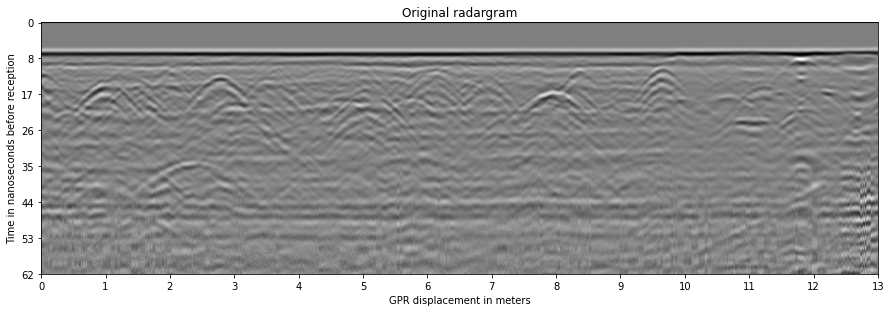

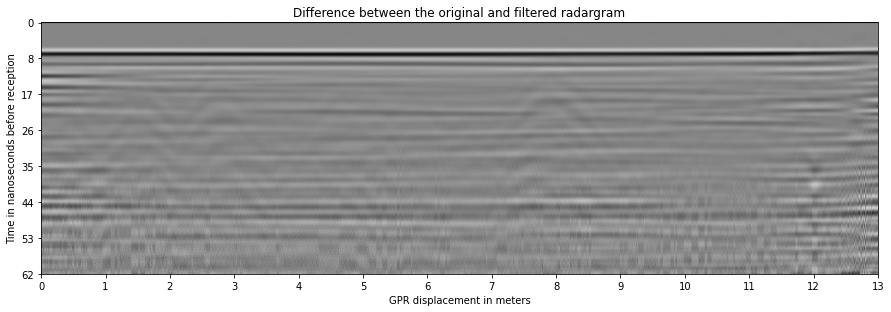

In [103]:
# Application filtre horizontal
bs_filtered = filter_by_butterworth(bs_vertical_filtered, [horizontal_low, horizontal_high], horizontal_sample_rate, 'band', vertical=False)
plot_radargram(bs_filtered, "Band-passed radargram with a butterworth filter with cutoff frequencies of [" + str(horizontal_low) + ", " + str(horizontal_high) + "] m⁻1")
plot_radargram(bs, "Original radargram")
plot_radargram(np.abs(bs - bs_filtered), "Difference between the original and filtered radargram")

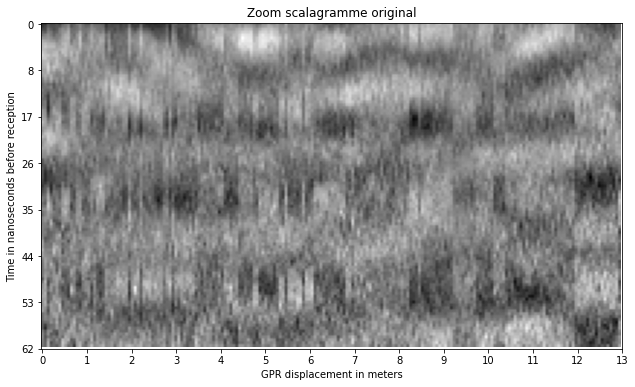

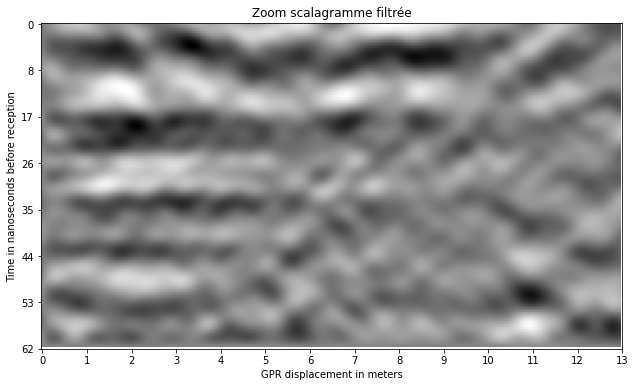

In [104]:
plot_radargram(bs[400:, :200], "Zoom scalagramme original")
plot_radargram(bs_filtered[400:, :200], "Zoom scalagramme filtrée")

## Comparaison entre la solution gardée et l'ancienne solution

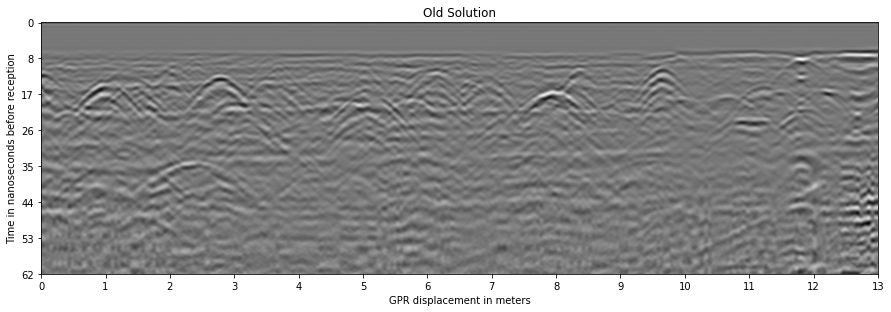

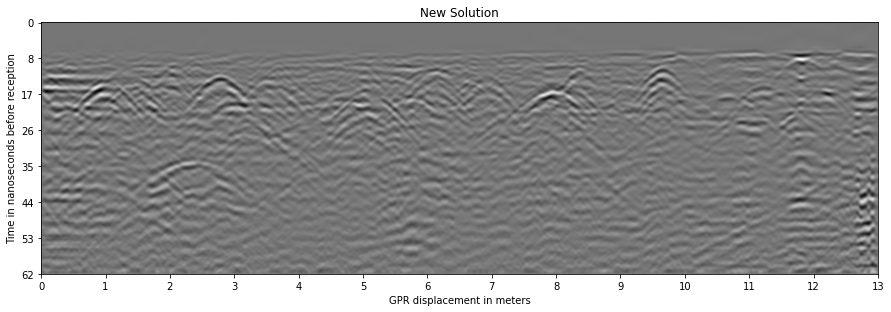

In [105]:
plot_radargram(bs_filtered_old, "Old Solution")
plot_radargram(bs_filtered, "New Solution")